In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from pysot.core.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker

from got10k.trackers import Tracker
from got10k.experiments import ExperimentGOT10k
from utils import scores
from utils import plotting
from IPython import display

import shutil
%matplotlib inline

In [2]:
def return_tracker(local_config):
    cfg.merge_from_file(local_config["config"])
    cfg.CUDA = torch.cuda.is_available() and cfg.CUDA
    device = torch.device('cuda' if cfg.CUDA else 'cpu')

    model = ModelBuilder()
    model.load_state_dict(torch.load(local_config["model"],
        map_location=lambda storage, loc: storage.cpu()))
    model.eval().to(device)

    return build_tracker(model)

In [3]:
class IdentityTracker(Tracker):
    def __init__(self, tracker_config, model_name):
        super(IdentityTracker, self).__init__(
            name=model_name, 
            is_deterministic=True   
        )
        self.tracker = return_tracker(tracker_config)
    
    def init(self, image, box):
        self.box = box
        open_cv_image = np.array(image) 
        self.tracker.init(open_cv_image, box)

    def update(self, image):
        open_cv_image = np.array(image) 
        outputs = self.tracker.track(open_cv_image)
        return np.array(outputs['bbox'], dtype=np.int64)

In [4]:
data_path1 = "./datasets/GOT/val/GOT-10k_Val_000006" # Машина classes = 2
data_path2 = "./datasets/GOT/val/GOT-10k_Val_000055" # Санки. Маленький объект. 
data_path3 = "./datasets/GOT/val/GOT-10k_Val_000147" # Медведь
data_path4 = "./datasets/GOT/val/GOT-10k_Val_000175" # Футболисты. Маленький объект.

data_path = data_path4
last_val_dir = data_path.split("/")[-1] 

In [5]:
## ДАЛЕЕ ЕСТЬ ТРЕБУЕТСЯ ЗАПУСТИТЬ ТЕСТ ТОЛЬКО ДЛЯ ОДНОЙ ВЫБОРКИ или ее изменить, ТО НУЖНО:
## datasets/GOT/vallist.txt добавить / удалить NAME_DIR тестовой выборки
f = open("./datasets/GOT/val/list.txt", "w")
f.write(last_val_dir)
f.close()

In [6]:
TRACK_CONFIG = {
    "config": "./pysot/experiments/siamrpn_alex_dwxcorr/config.yaml",
    "model": "./pysot/models/rpn_alex.pth",
}
model_name = "SiameseRPN"
tracker = IdentityTracker(TRACK_CONFIG, "SiameseRPN")
experiment = ExperimentGOT10k(
        root_dir="./datasets/GOT",  # GOT-10k's root directory
        subset='val',                    # 'train' | 'val' | 'test'
        result_dir='sot_tracking_results',       # where to store tracking results
        report_dir='reports'        # where to store evaluation reports
    )

Running tracker SiameseRPN on GOT-10k...
--Sequence 1/1: GOT-10k_Val_000175
 Repetition: 1
  Results recorded at sot_tracking_results\GOT-10k\SiameseRPN\GOT-10k_Val_000175\GOT-10k_Val_000175_001.txt
Evaluating SiameseRPN
Saving success plots to reports\GOT-10k\SiameseRPN\success_plot.png


{'SiameseRPN': {'overall': {'ao': 0.04482026273173379,
   'sr': 0.05925925925925926,
   'speed_fps': 45.5804362057914,
   'succ_curve': [0.06666666666666667,
    0.06666666666666667,
    0.06666666666666667,
    0.06666666666666667,
    0.06666666666666667,
    0.06666666666666667,
    0.06666666666666667,
    0.06666666666666667,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296296296,
    0.06296296296

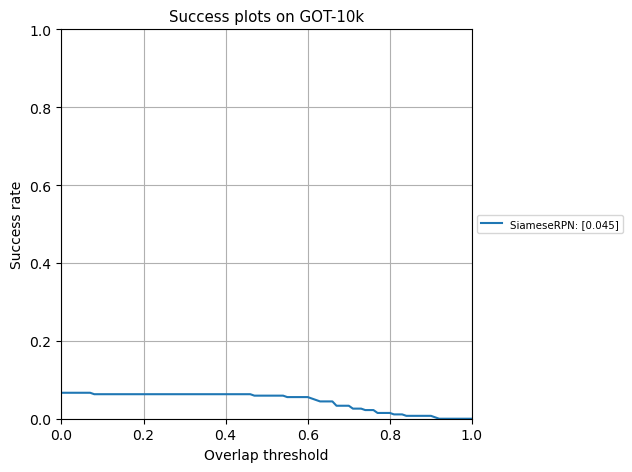

In [7]:
# Подчищаем предыдущие
RESULTS_DIR = f"./sot_tracking_results/GOT-10k/{model_name}"
REPORT_DIR = f"./reports/GOT-10k/{model_name}"
try:
    shutil.rmtree(RESULTS_DIR)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))
try:
    shutil.rmtree(REPORT_DIR)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

experiment.run(tracker, visualize=False)
experiment.report([tracker.name])

In [8]:
scores.get_scores(f"./datasets/GOT/val/{last_val_dir}/groundtruth.txt", f"sot_tracking_results/GOT-10k/SiameseRPN/{last_val_dir}/{last_val_dir}_001.txt")

--- Evaluate for GOT-10k ---
Average Overlap (AO): 4.83 %
Success 0.5 (SR0.5): 6.27 %
Success 0.75 (SR0.75): 2.58 %
--- Evaluate for TrackingNet & LaSOT ---
Success score (AUC): 4.80 %
Precision score (P): 7.38 %
NPrecision score (P_norm): 5.14 %


In [9]:
img_names = list(filter(lambda file: file.endswith(".jpg"), os.listdir(data_path)))
img_names.sort()

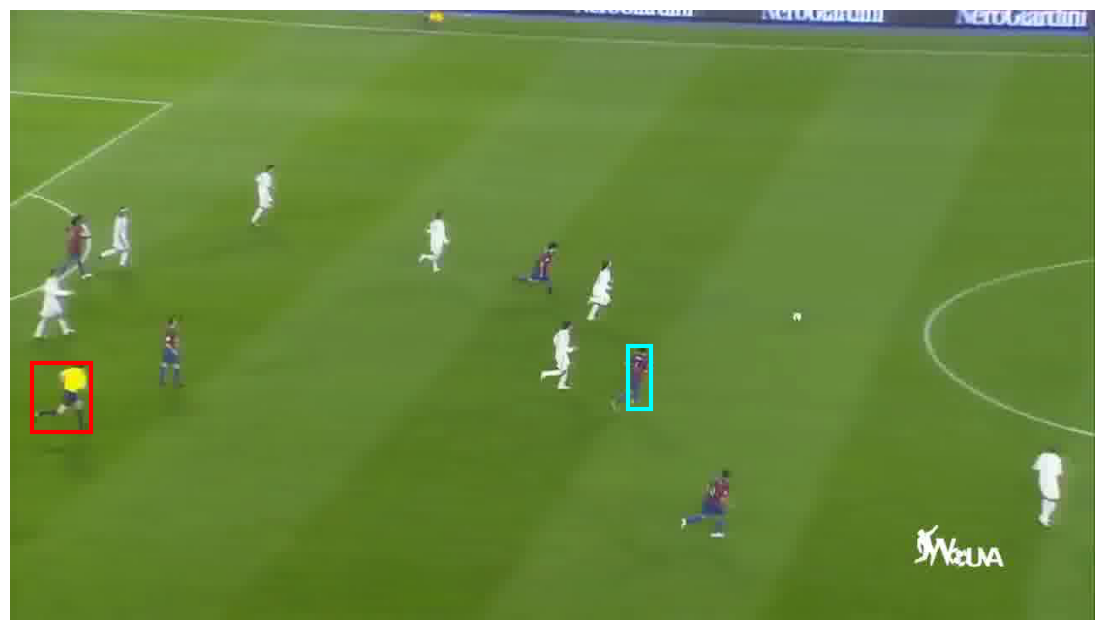

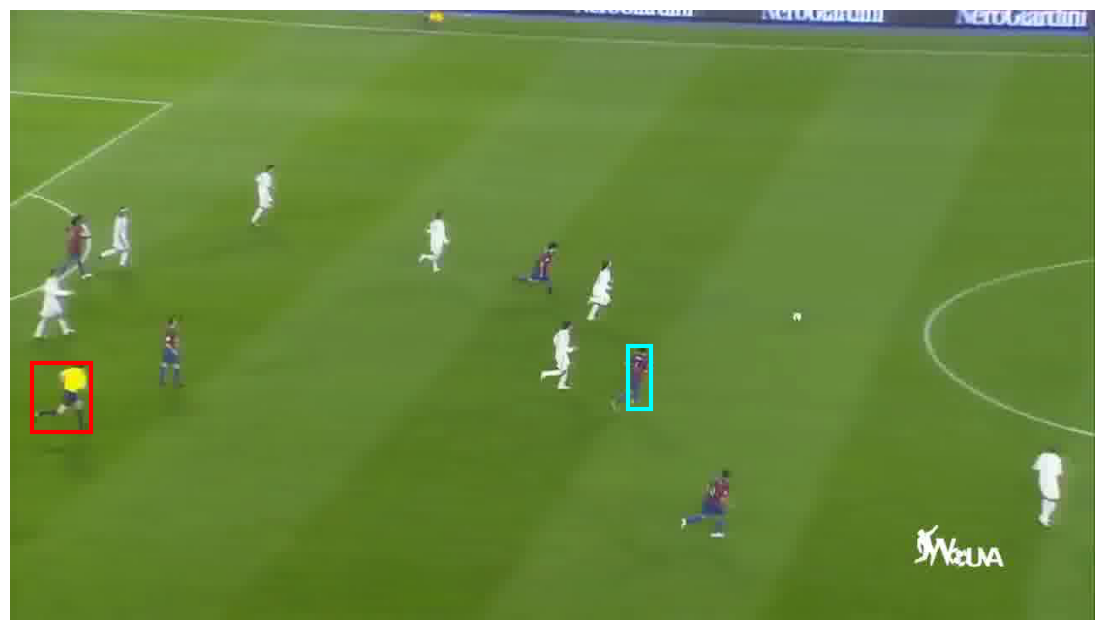

In [10]:
tracker = return_tracker(TRACK_CONFIG)
fisrt_img = True
gt_boxes = np.loadtxt(data_path + "/groundtruth.txt", delimiter=',')

fig, ax = plt.subplots(1, 1, figsize=(14, 14))

for img_name, gt_box in zip(img_names, gt_boxes):
    img = cv2.imread(os.path.join(data_path, img_name))

    if fisrt_img:
        fisrt_img = False
        tracker.init(img, gt_box)
    else:
        outputs = tracker.track(img)
        
        ax.clear()
        display.clear_output(wait=True)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plotting.add_obj_bbox_to_plot(ax, np.array(outputs['bbox'], dtype=np.int64), plotting.COLOURS[0], centered=False)
        plotting.add_obj_bbox_to_plot(ax, np.array(gt_box, dtype=np.int64), "red", centered=False)
        ax.axis('off')
        ax.plot()
        display.display(fig)


    